In [1]:
import tensorflow as tf


In [2]:
def modelo_mlp (input_dim):
    model = models.Sequential([
        
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model
     

In [3]:
import pandas as pd
import numpy as np

# DATOS PRUEBA  
datos_prueba = {
    'src_port': np.random.randint(1024, 65535, 100),
    'dst_port': [80]*100,
    'proto': [6]*100,
    'packets': np.random.randint(1, 1000, 100),
    'bytes': np.random.randint(64, 100000, 100),
    'first_seen_sec': [1700000000]*100,
    'last_seen_sec': [1700000005]*100,
    'first_seen_usec': [0]*100,
    'last_seen_usec': [0]*100
}

\
pd.DataFrame(datos_prueba).to_csv('datos_entrada.csv', index=False)
print("Archivo 'datos_entrada.csv' generado para pruebas.")

Archivo 'datos_entrada.csv' generado para pruebas.


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1.  columnas  del CSV
columnas = ['src_ip', 'dst_ip', 'proto', 'duration', 'packets', 'bytes', 'pps', 'bps', 'bpp']

# 2. Carga del archivo
df = pd.read_csv('flows.csv', header=None, names=columnas)

# Creamos el tamaño promedio del paquete 
df['avg_pkt'] = df['bytes'] / df['packets'].replace(0, 1)

# Creamos una métrica de intensidad combinada
df['intensity'] = df['pps'] * df['bps']



features = ['proto', 'duration', 'packets', 'bytes', 'pps', 'bps', 'bpp', 'avg_pkt', 'intensity']
X = df[features]

# 4. Normalizamos los datos 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Creamos los sets de entrenamiento y prueba
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

print(f"¡Listo! Datos cargados con {len(features)} características.")
print("Las nuevas variables 'avg_pkt' e 'intensity' ya están integradas.")


¡Listo! Datos cargados con 9 características.
Las nuevas variables 'avg_pkt' e 'intensity' ya están integradas.


In [11]:
from sklearn.ensemble import IsolationForest


iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Entrenar 
iso_forest.fit(X_train)

#  -1 es anomalía  1 es normal
y_pred = iso_forest.predict(X_test)

In [12]:
# cuántos normales (1) y cuántas anomalías (-1) detecta
resultados = pd.Series(y_pred).value_counts()
print("Detecciones del modelo:")
print(resultados)

# ver porcentaje 
anomalias_porcentaje = (resultados.get(-1, 0) / len(y_pred)) * 100
print(f"\nPorcentaje de anomalías detectadas: {anomalias_porcentaje:.2f}%")

Detecciones del modelo:
 1    30
-1     1
Name: count, dtype: int64

Porcentaje de anomalías detectadas: 3.23%


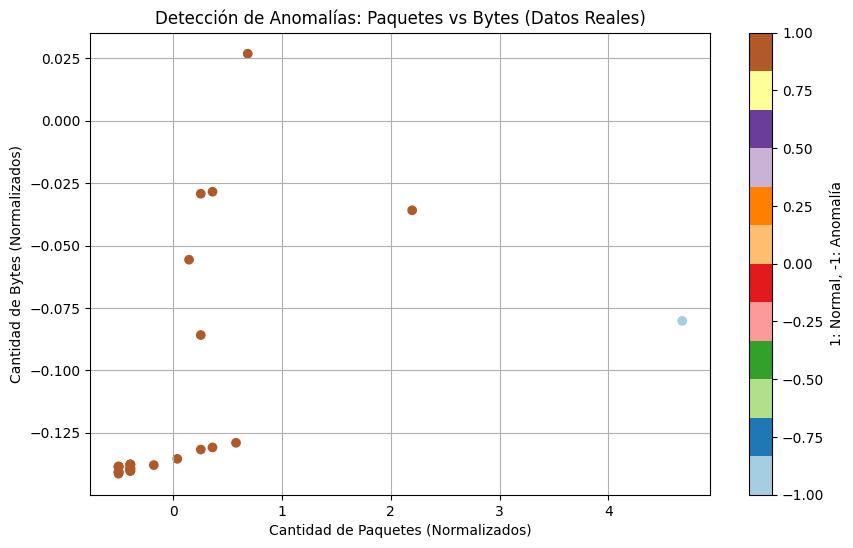

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# [:, 2] para todos los elementos de la columna 'packets' 
# [:, 3] para todos los elementos de la columna 'bytes'
plt.scatter(X_test[:, 2], X_test[:, 3], c=y_pred, cmap='Paired', label='Tráfico')

plt.title('Detección de Anomalías: Paquetes vs Bytes (Datos Reales)')
plt.xlabel('Cantidad de Paquetes (Normalizados)')
plt.ylabel('Cantidad de Bytes (Normalizados)')
plt.colorbar(label='1: Normal, -1: Anomalía')
plt.grid(True)
plt.show()

In [29]:
def etiquetar_trafico(row):
    # Regla para SCAN: Pocos paquetes y tamaño promedio chico (poca carga útil)
    if row['packets'] < 5 and row['avg_pkt'] < 100:
        return 'SCAN'
    
    # Regla para FLOOD: Alta intensidad de tráfico (PPS) y muchos bytes
    # Ajustamos los umbrales según el comportamiento típico de red
    if row['pps'] > 10 and row['bytes'] > 500000:
        return 'FLOOD'
    
    return 'NORMAL'

# Aplicamos la función al DataFrame original
df['etiqueta_esperada'] = df.apply(etiquetar_trafico, axis=1)

print("Distribución de tráfico ")
print(df['etiqueta_esperada'].value_counts())

Distribución de tráfico 
etiqueta_esperada
NORMAL    115
SCAN       38
Name: count, dtype: int64


In [28]:
from sklearn.ensemble import IsolationForest

# Entrenamos el modelo con las features mejoradas y normalizadas
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train)

# Predecimos sobre todo el set para comparar
df['prediccion_ia'] = iso_forest.predict(scaler.transform(df[features]))

# Comparamos: ¿Cuántos SCAN/FLOOD detectó la IA como anomalía?
comparacion = df.groupby(['etiqueta_esperada', 'prediccion_ia']).size().unstack(fill_value=0)
print("\nComparación (IA vs Teoría):")
print(comparacion)


Comparación (IA vs Teoría):
prediccion_ia      -1   1
etiqueta_esperada        
NORMAL             17  98
SCAN                0  38


In [27]:
# Aumentamos la contaminación 
iso_forest = IsolationForest(contamination=0.2, random_state=42)
iso_forest.fit(X_train)

# Re-predecir
df['prediccion_ia'] = iso_forest.predict(scaler.transform(df[features]))


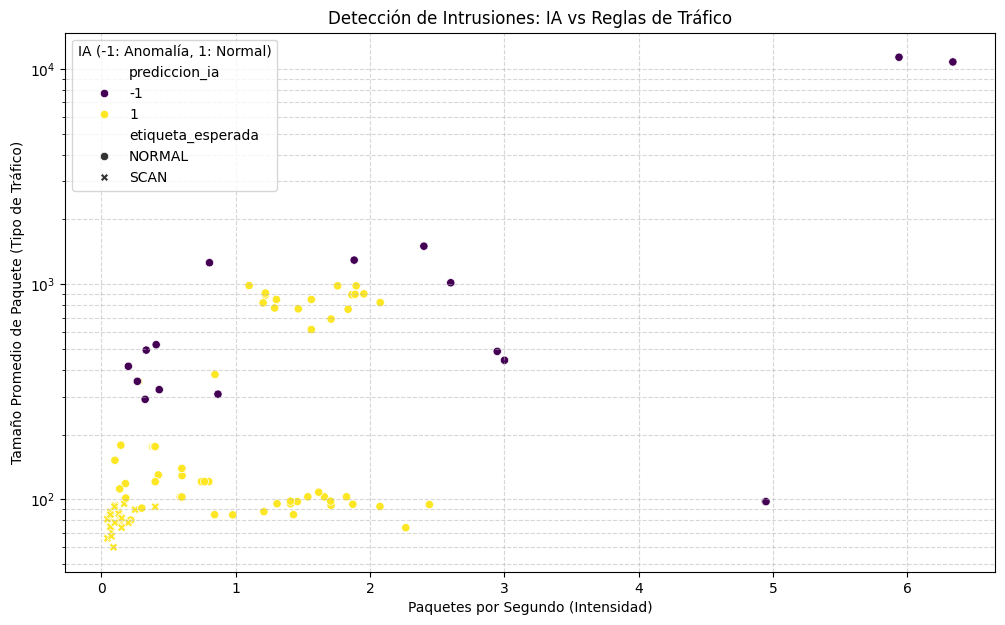

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='pps', y='avg_pkt', hue='prediccion_ia', style='etiqueta_esperada', palette='viridis')

plt.title('Detección de Intrusiones: IA vs Reglas de Tráfico')
plt.xlabel('Paquetes por Segundo (Intensidad)')
plt.ylabel('Tamaño Promedio de Paquete (Tipo de Tráfico)')
plt.yscale('log') # Escala logarítmica para ver mejor los bytes
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend(title='IA (-1: Anomalía, 1: Normal)')
plt.show()

In [31]:
def monitorear_alertas(dataframe):
    print("--- INICIANDO MONITOREO DE SEGURIDAD ---")
    for i, row in dataframe.iterrows():
        if row['prediccion_ia'] == -1:
            # Si es anomalía, determinamos qué tipo podría ser 
            tipo = "ANOMALÍA DESCONOCIDA"
            if row['avg_pkt'] < 100:
                tipo = "POSIBLE SCAN (Paquetes pequeños)"
            elif row['pps'] > 5:
                tipo = "POSIBLE FLOOD (Alta intensidad)"
            
            print(f"⚠️ [ALERTA] Flujo {i}: {tipo} | IP Origen: {row['src_ip']}")

# Ejecutar alerta sobre los datos actuales
monitorear_alertas(df)

--- INICIANDO MONITOREO DE SEGURIDAD ---
⚠️ [ALERTA] Flujo 6: POSIBLE FLOOD (Alta intensidad) | IP Origen: 159001288
⚠️ [ALERTA] Flujo 8: POSIBLE SCAN (Paquetes pequeños) | IP Origen: 1409329344
⚠️ [ALERTA] Flujo 15: POSIBLE SCAN (Paquetes pequeños) | IP Origen: 1409329344
⚠️ [ALERTA] Flujo 17: POSIBLE FLOOD (Alta intensidad) | IP Origen: 159001288
⚠️ [ALERTA] Flujo 37: ANOMALÍA DESCONOCIDA | IP Origen: 1409329344
⚠️ [ALERTA] Flujo 38: ANOMALÍA DESCONOCIDA | IP Origen: 1066251828
⚠️ [ALERTA] Flujo 51: ANOMALÍA DESCONOCIDA | IP Origen: 1409329344
⚠️ [ALERTA] Flujo 58: ANOMALÍA DESCONOCIDA | IP Origen: 1409329344
⚠️ [ALERTA] Flujo 84: ANOMALÍA DESCONOCIDA | IP Origen: 1409329344
⚠️ [ALERTA] Flujo 88: ANOMALÍA DESCONOCIDA | IP Origen: 3297180558
⚠️ [ALERTA] Flujo 95: ANOMALÍA DESCONOCIDA | IP Origen: 1409329344
⚠️ [ALERTA] Flujo 102: ANOMALÍA DESCONOCIDA | IP Origen: 151038144
⚠️ [ALERTA] Flujo 107: ANOMALÍA DESCONOCIDA | IP Origen: 618707491
⚠️ [ALERTA] Flujo 110: ANOMALÍA DESCONOCIDA | 

In [32]:
def generar_reporte_anomalias(df, filename="reporte_seguridad.txt"):
    anomalias = df[df['prediccion_ia'] == -1]
    
    with open(filename, "w") as f:
        f.write("==========================================\n")
        f.write("   REPORTE DE DETECCIÓN DE INTRUSIONES    \n")
        f.write(f"   Fecha: {pd.Timestamp.now()}\n")
        f.write("==========================================\n\n")
        
        if anomalias.empty:
            f.write("No se detectaron anomalías en el tráfico analizado.\n")
        else:
            f.write(f"Se detectaron {len(anomalias)} flujos sospechosos.\n\n")
            for i, row in anomalias.iterrows():
                # Clasificación basada en la lógica de Nesdann
                if row['avg_pkt'] < 100 and row['packets'] < 5:
                    tipo = "POSIBLE SCAN (Port Scanning)"
                elif row['pps'] > 5:
                    tipo = "POSIBLE FLOOD (DoS Attempt)"
                else:
                    tipo = "ANOMALÍA GENÉRICA (Comportamiento inusual)"
                
                f.write(f"ALERTA #{i+1}:\n")
                f.write(f" - Tipo: {tipo}\n")
                f.write(f" - IP Origen: {row['src_ip']} -> IP Destino: {row['dst_ip']}\n")
                f.write(f" - Detalles: {row['packets']} pkts, {row['bytes']} bytes, {row['avg_pkt']:.2f} avg_pkt\n")
                f.write("-" * 30 + "\n")
                
    print(f"Reporte generado con éxito: {filename}")

# Ejecutamos la función
generar_reporte_anomalias(df)

Reporte generado con éxito: reporte_seguridad.txt


In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
df['target'] = le.fit_transform(df['etiqueta_esperada']) 

# 2. Definimos las clases (ej: 0: FLOOD, 1: NORMAL, 2: SCAN)
num_classes = len(le.classes_)
y = to_categorical(df['target'], num_classes)

# Usamos las X_train y X_test 

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 1. Preparamos las etiquetas (Y)
# Usamos la columna 'etiqueta_esperada' que creamos con la lógica de Nesdann
le = LabelEncoder()
y_numeric = le.fit_transform(df['etiqueta_esperada'])

# Convertimos a formato categórico para la Red Neuronal (One-Hot Encoding)
y_categorical = to_categorical(y_numeric)

# 2. Volvemos a hacer el split, pero esta vez incluyendo la 'y'
# IMPORTANTE: Usamos X_scaled que ya estaba normalizado
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y_categorical, 
    test_size=0.2, 
    random_state=42
)

print(f"¡Listo! y_train definido con éxito.")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")

¡Listo! y_train definido con éxito.
Forma de X_train: (122, 9)
Forma de y_train: (122, 2)


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers


tf.keras.backend.clear_session()


ann = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(8, activation='relu'),
    layers.Dense(y_train.shape[1], activation='softmax') # debe ser 3 (Normal, Scan, Flood)
])


ann.compile(optimizer='adam', 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

# 4. Entrenar (Ahora debería correr sin errores)
print("Iniciando entrenamiento de la Red Neuronal...")
history = ann.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.1)

Iniciando entrenamiento de la Red Neuronal...
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4587 - loss: 0.8118 - val_accuracy: 0.5385 - val_loss: 0.6935
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6972 - loss: 0.7362 - val_accuracy: 0.5385 - val_loss: 0.6506
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8257 - loss: 0.6658 - val_accuracy: 0.7692 - val_loss: 0.6220
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8991 - loss: 0.6172 - val_accuracy: 0.7692 - val_loss: 0.6052
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9358 - loss: 0.5792 - val_accuracy: 0.7692 - val_loss: 0.5891
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9358 - loss: 0.5505 - val_accuracy: 0.7692 - val_loss: 0.5725
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9358 - loss: 0.5238 - val_accuracy: 0.7692 - val_loss: 0.5595
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9358 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


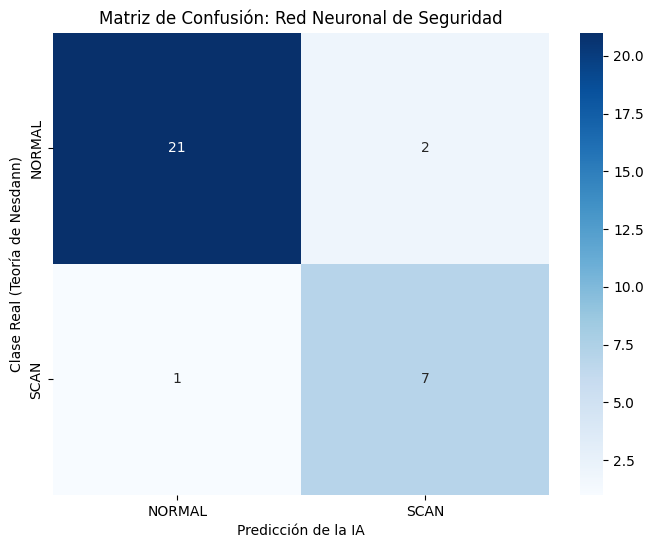

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

      NORMAL       0.95      0.91      0.93        23
        SCAN       0.78      0.88      0.82         8

    accuracy                           0.90        31
   macro avg       0.87      0.89      0.88        31
weighted avg       0.91      0.90      0.90        31



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1. Obtener las predicciones del modelo sobre el set de prueba
y_pred_probs = ann.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 2. Generar la matriz
cm = confusion_matrix(y_true_classes, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión: Red Neuronal de Seguridad')
plt.xlabel('Predicción de la IA')
plt.ylabel('Clase Real (Teoría de Nesdann)')
plt.show()




print("Reporte de Clasificación Detallado:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

In [ ]:
import joblib

# 1. Guardar la Red Neuronal (formato Keras)
ann.save('ids_neural_model.h5')

# 2. Guardar el Scaler y el LabelEncoder 
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("¡Arquitectura de defensa exportada! Archivos generados: ids_neural_model.h5, scaler.pkl, label_encoder.pkl")

¡Arquitectura de defensa exportada! Archivos generados: ids_neural_model.h5, scaler.pkl, label_encoder.pkl
